# Correlation and slope

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1c6wdyy/q_negative_correlation_but_a_positive_trend_line/).

> I am currently doing a uni assignment and one of my tasks is analysing the correlation between two variables. When I use the correlation function in Excel, it returns a correlation of -0.0377. When I use the same data to create a scatter plot, the trend line is positive. I need to identify the correlation strength and direction and thereby, I am confused by these opposing outcomes. Can somebody please explain why the correlation is showing as negative but the trend line is positive? What does this indicate in terms of the strength and direction of the relationship between the two variables? 

To answer the immediate question, correlation and the slope of a linear regression line always have the same sign.
Mathematically, they are both related to the dot product of the `x` and `y` variables.

So there is something strange going on.
It might be a simple error -- for example, maybe the correlation and regression were based on different data.
Or it might be that the trend computed by Excel is something other than linear regression.
For example, a line that minimizes mean absolute error (MAE) rather than mean squared error (MSE) can have a slope with the opposite sign of the correlation.

Without more information it's hard to be sure what's going on, but for this example it might not matter.
The computed correlation is negative but very small.
If we fit a line (other than a regression line) to the same data and the slope is positive but similarly small, that is not necessarily inconsistent.
Within statistical uncertainty, both are indistinguishable from zero.

OP also asks, "What does this indicate in terms of the strength and direction of the relationship between the two variables?"
So let's answer that question, too.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/corr_trend.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

## Interpreting correlation and slope

When people talk about the strength of a relationship, they might mean correlation or they might mean the slope of a fitted line.
But these measures of "strength" are not always consistent.

For example, suppose we are concerned about the health effects of weight gain, so we plot weight versus age from 20 to 50 years old.
I'll generate two fake datasets to demonstrate the point.

In [2]:
np.random.seed(18)
xs1 = np.linspace(20, 50)
ys1 = 75 + 0.02 * xs1 + np.random.normal(0, 0.15, len(xs1))

In [3]:
np.random.seed(18)
xs2 = np.linspace(20, 50)
ys2 = 65 + 0.2 * xs2 + np.random.normal(0, 3, len(xs2))

I used the same random seed to generate both, so they look similar, as we can see in these scatter plots.

In [4]:
from utils import underride

def text(x, y, string, **options):
    """Plot text using axis coordinates.
    """
    transform = plt.gca().transAxes
    options = underride(options, transform=transform, ha='left', va='top')
    plt.text(x, y, string, **options)

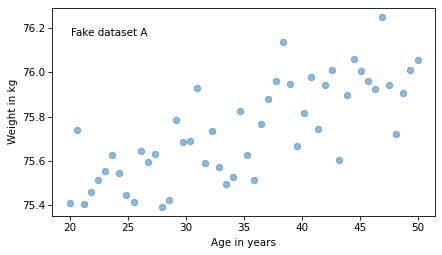

In [5]:
plt.plot(xs1, ys1, 'o', alpha=0.5)
text(0.05, 0.9, 'Fake dataset A')
decorate(xlabel='Age in years',
         ylabel='Weight in kg')

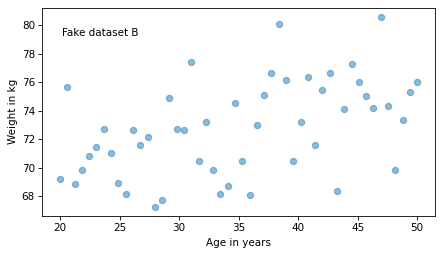

In [6]:
plt.plot(xs2, ys2, 'o', alpha=0.5)
text(0.05, 0.9, 'Fake dataset B')
decorate(xlabel='Age in years',
         ylabel='Weight in kg')

Nevertheless, they have substantially different correlations.

In [7]:
rho1 = np.corrcoef(xs1, ys1)[0][1]
rho1

0.7579660563439401

In [8]:
rho2 = np.corrcoef(xs2, ys2)[0][1]
rho2

0.4782776976576317

In the first dataset, the correlation is close to `0.75`.
In the second, it is close to `0.5`.
So we might think the first relationship is stronger.

But let's look at the slopes of the regression lines.
For the first dataset, the estimated slope is about 0.019 kilograms per year or about 0.56 kilograms over the 30-year range.

In [9]:
from scipy.stats import linregress

res1 = linregress(xs1, ys1)
res1.slope, res1.slope * 30

(0.018821034903244386, 0.5646310470973316)

For the second dataset, the estimated slope is almost 10 times higher -- about 0.18 kilograms per year or 5.3 kilograms per 30 years.

In [10]:
res2 = linregress(xs2, ys2)
res2.slope, res2.slope * 30

(0.17642069806488855, 5.292620941946657)

According to the correlations, the first relationship is stronger.
According to the slopes, the second relationship is stronger.
So which is it?
The answer depends on context.

In this example, the slope of the regression line indicates the magnitude of weight gain.
If we are concerned about the health effects of weight gain, the second relationship is probably more important.

On the other hand, correlation indicates how well we can predict one value based on the other.
If, for some reason, we are trying to guess someone's weight, based on their age, the first relationship would be more important.

Here are all the results in the same plot.

In [11]:
def make_plot(xs, ys, title):
    """Make a scatter plot with fitted line.
    """
    res = linregress(xs, ys)
    plt.plot(xs, ys, 'o', alpha=0.5)

    fx = np.array([xs.min(), xs.max()])
    fy = res.intercept + res.slope * fx
    plt.plot(fx, fy, '-')

    text(0.05, 0.9, title)
    text(0.05, 0.82, f'correlation = {res.rvalue:0.2f}')
    text(0.05, 0.74, f'slope = {res.slope:0.3f} kg/yr')
    decorate(xlabel='Age in years',
             ylabel='Weight in kg')

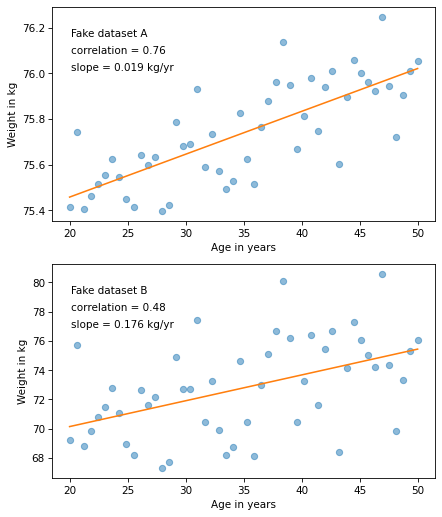

In [12]:
plt.figure(figsize=(6, 7))

plt.subplot(2, 1, 1)
make_plot(xs1, ys1, 'Fake dataset A')

plt.subplot(2, 1, 2)
make_plot(xs2, ys2, 'Fake dataset B')

Because of the way the plots are scaled, the slope looks smaller in the second figure, but that's misleading.
So this example is a reminder to look at the labels of the `y` axis -- which is where the effect size often hides.

## Minimizing MAE

Earlier I said a line that minimizes mean absolute error (MAE) rather than mean squared error (MSE) can have a slope with the opposite sign of the correlation.
To demonstrate, I'll use the following function to minimize MAE.

In [13]:
from scipy.optimize import minimize

def error_func(params, xs, ys):
    intercept, slope = params
    y_pred = intercept + slope * xs
    return np.mean(np.abs(y_pred - ys))

def minimize_mae(xs, ys):
    param0 = [0, 0]
    result = minimize(error_func, param0, args=(xs, ys), method='Nelder-Mead')
    assert result.success
    
    return result.x

Now I'll generate a dataset where `xs` and `ys` are actually uncorrelated.

In [14]:
n = 100

np.random.seed(20)
xs = np.random.normal(0, 1, n)
ys = np.random.normal(0, 1, n)

In this dataset, the correlation is slightly negative and the slope of the fitted line is slightly positive.

In [15]:
corr = np.corrcoef(xs, ys)[0, 1]
intercept, slope = minimize_mae(xs, ys)

corr, slope

(-0.08198650127894906, 0.04675271007547886)

Here's what the scatter plot looks like with the minimum MAE line. 

In [16]:
fxs = np.array([np.min(xs), np.max(xs)])
fys = intercept + slope * fxs

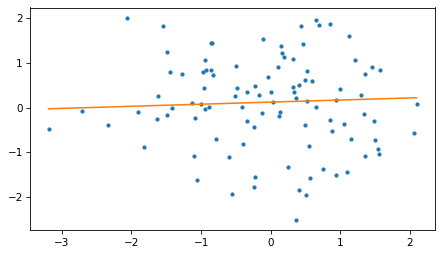

In [17]:
plt.plot(xs, ys, '.')
plt.plot(fxs, fys)
decorate()

To find this example, I generated datasets with different random number seeds.
Out of the first 100 attempts, 19 yield correlation and slope with opposite signs.

In [18]:
count = 0
for i in range(100):
    np.random.seed(i)
    xs = np.random.normal(0, 1, n)
    ys = np.random.normal(0, 1, n)
    corr = np.corrcoef(xs, ys)[0, 1]
    intercept, slope = minimize_mae(xs, ys)
    if corr * slope < 0:
        count += 1
count

19

So examples like this are not rare, if the actual correlation is close to zero.

*Data Q&A: Answering the real questions with Python*

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)